In [1]:
from google.colab import drive
import pandas as pd
import numpy as np

# Preprocessing Text
!pip install sastrawi
import requests
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
nltk.download('stopwords')
nltk.download('punkt_tab')

# Pelabelan
import requests
import matplotlib.pyplot as plt

# Eksplorasi Label
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

# Data Splitting dan Ekstraksi Fitur dengan TF-IDF
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Modeling
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense, SpatialDropout1D, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Save Models
import pickle
from google.colab import files

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.7 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


# Load Dataset

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/dataset/ulasan_aplikasi.csv')

# Exploratory Data Analysis (EDA)

In [ ]:
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,e97f0fd3-31eb-4f5f-8d38-48418c481ae6,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,tepat waktu,5,0,5.12.1,2025-04-08 15:25:11,NaN,NaN,5.12.1
1,759ecedf-91eb-40d8-b522-f7a63e5c9c55,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"tolonglah gojek, app ini udh bagus dan jga san...",3,0,5.15.1,2025-04-08 15:18:19,"Mohon maaf atas ketidaknyamanannya, Kak Fadila...",2025-04-08 16:19:13,5.15.1
2,98455c0d-f683-47d4-9ef2-92b58c86ffb0,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,bagus,5,0,5.15.1,2025-04-08 15:14:59,NaN,NaN,5.15.1
3,64d2dcd6-473e-4598-838b-5f26078f5cf6,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,mantap,5,0,NaN,2025-04-08 15:13:22,NaN,NaN,NaN
4,11414fd4-c35d-47d3-a8ee-504e4a259f13,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,sangat membantu disaat dibutuhkan,5,0,NaN,2025-04-08 15:13:09,NaN,NaN,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              30000 non-null  object
 1   userName              30000 non-null  object
 2   userImage             30000 non-null  object
 3   content               30000 non-null  object
 4   score                 30000 non-null  int64 
 5   thumbsUpCount         30000 non-null  int64 
 6   reviewCreatedVersion  23388 non-null  object
 7   at                    30000 non-null  object
 8   replyContent          9978 non-null   object
 9   repliedAt             9978 non-null   object
 10  appVersion            23388 non-null  object
dtypes: int64(2), object(9)
memory usage: 2.5+ MB


In [ ]:
clean_df = df.copy()
clean_df = clean_df.drop(columns=['userName', 'reviewId', 'userImage', 'thumbsUpCount', 'reviewCreatedVersion', 'at', 'replyContent', 'repliedAt', 'appVersion'])
clean_df = clean_df.dropna()
clean_df = clean_df.drop_duplicates()

In [ ]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22060 entries, 0 to 29999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  22060 non-null  object
 1   score    22060 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 517.0+ KB


# Preprocessing Text

In [ ]:
slangwords = {"pda": "pada", "apk": "aplikasi", "pdhl": "padahal", "bbrp": "beberapa", "cm": "cuma", "yth": "yang terhormat", "nyman": "nyaman", "baikk": "baik", "mantaaaffff": "mantap", "udha": "sudah", "drever": "driver", "gmpang": "gampang", "yapadahalgopay": "padahal gopay", "rb": "ribu", "mantulll": "mantul", "bagusd": "bagus", "lbh": "lebih", "ganiat": "tidak niat", "jlk": "jelek", "bngttt": "banget", "paraahhh": "parah", "paraahhhhhhhh": "parah", "bngttt": "banget", "njing": "anjing", "sya": "saya", "sbg": "sebagai", "jls": "jelas", "tngkatkan": "tingkatkan", "mantapz": "mantap", "kyaknya": "sepertinya", "matapp": "mantap", "bangeeeet": "banget", "jlek": "jelek", "gojekbike": "gojek bike", "digunakn": "digunakan", "g": "tidak", "gojeg": "gojek", "smoga": "semoga", "cri": "mencari", "gabisa": "tidak bisa", "gatau": "tidak tahu", "anying": "anjing", "gak": "tidak", "sgttt": "sangat", "skrang": "sekarang", "gda": "tidak ada", "skli": "sekali", "pesen": "pesan", "bagussangat": "bagus sangat", "mesen": "pesan", "cepatdriver": "cepat driver", "nerima": "terima", "matap": "mantap", "udh": "sudah", "skrg": "sekarang", "gajelas": "tidak jelas", "gada": "tidak ada", "bgus": "bagus", "ngak": "tidak", "gk": "tidak", "gmn": "bagaimana", "gajelas": "tidak jelas", "ramahberkendara": "ramah berkendara", "dng": "dengan", "kesel": "kesal", "gojekindonesia": "gojek indonesia", "masukbuat": "masukbuat", "moga": "semoga", "sdh": "sudah", "ngebantu": "membantu", "emg": "memang", "kdng": "kadang", "klu": "kalau", "gaguna": "tidak berguna", "bgs": "bagus", "bermanfaatbnyk": "bermanfaat banyak", "lusuper": "super", "tlg": "tolong", "trimksh": "terima kasih", "hbis": "habis", "sngt": "sangat", "@": "di", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual", "wtt": "tukar", "bgt": "banget", "maks": "maksimal", "plisss": "tolong", "bgttt": "banget", "indo": "indonesia", "bgtt": "banget", "ad": "ada", "rv": "redvelvet", "plis": "tolong", "pls": "tolong", "cr": "sumber", "cod": "bayar ditempat", "adlh": "adalah", "afaik": "as far as i know", "ahaha": "haha", "aj": "saja", "ajep-ajep": "dunia gemerlap", "ak": "saya", "akika": "aku", "akkoh": "aku", "akuwh": "aku", "alay": "norak", "alow": "halo", "ambilin": "ambilkan", "ancur": "hancur", "anjrit": "anjing", "anter": "antar", "ap2": "apa-apa", "apasih": "apa sih", "apes": "sial", "aps": "apa", "aq": "saya", "aquwh": "aku", "asbun": "asal bunyi", "aseekk": "asyik", "asekk": "asyik", "asem": "asam", "aspal": "asli tetapi palsu", "astul": "asal tulis", "ato": "atau", "au ah": "tidak mau tahu", "awak": "saya", "ay": "sayang", "ayank": "sayang", "b4": "sebelum", "bakalan": "akan", "bandes": "bantuan desa", "bangedh": "banget", "banpol": "bantuan polisi", "banpur": "bantuan tempur", "basbang": "basi", "bcanda": "bercanda", "bdg": "bandung", "begajulan": "nakal", "beliin": "belikan", "bencong": "banci", "bentar": "sebentar", "ber3": "bertiga", "beresin": "membereskan", "bete": "bosan", "beud": "banget", "bg": "abang", "bgmn": "bagaimana", "bgt": "banget", "bijimane": "bagaimana", "bintal": "bimbingan mental", "bkl": "akan", "bknnya": "bukannya", "blegug": "bodoh", "blh": "boleh", "bln": "bulan", "blum": "belum", "bnci": "benci", "bnran": "yang benar", "bodor": "lucu", "bokap": "ayah", "boker": "buang air besar", "bokis": "bohong", "boljug": "boleh juga", "bonek": "bocah nekat", "boyeh": "boleh", "br": "baru", "brg": "bareng", "bro": "saudara laki-laki", "bru": "baru", "bs": "bisa", "bsen": "bosan", "bt": "buat", "btw": "ngomong-ngomong", "buaya": "tidak setia", "bubbu": "tidur", "bubu": "tidur", "bumil": "ibu hamil", "bw": "bawa", "bwt": "buat", "byk": "banyak", "byrin": "bayarkan", "cabal": "sabar", "cadas": "keren", "calo": "makelar", "can": "belum", "capcus": "pergi", "caper": "cari perhatian", "ce": "cewek", "cekal": "cegah tangkal", "cemen": "penakut", "cengengesan": "tertawa", "cepet": "cepat", "cew": "cewek", "chuyunk": "sayang", "cimeng": "ganja", "cipika cipiki": "cium pipi kanan cium pipi kiri", "ciyh": "sih", "ckepp": "cakep", "ckp": "cakep", "cmiiw": "correct me if i'm wrong", "cmpur": "campur", "cong": "banci", "conlok": "cinta lokasi", "cowwyy": "maaf", "cp": "siapa", "cpe": "capek", "cppe": "capek", "cucok": "cocok", "cuex": "cuek", "cumi": "Cuma miscall", "cups": "culun", "curanmor": "pencurian kendaraan bermotor", "curcol": "curahan hati colongan", "cwek": "cewek", "cyin": "cinta", "d": "di", "dah": "deh", "dapet": "dapat", "de": "adik", "dek": "adik", "demen": "suka", "deyh": "deh", "dgn": "dengan", "diancurin": "dihancurkan", "dimaafin": "dimaafkan", "dimintak": "diminta", "disono": "di sana", "dket": "dekat", "dkk": "dan kawan-kawan", "dll": "dan lain-lain", "dlu": "dulu", "dngn": "dengan", "dodol": "bodoh", "doku": "uang", "dongs": "dong", "dpt": "dapat", "dri": "dari", "drmn": "darimana", "drtd": "dari tadi", "dst": "dan seterusnya", "dtg": "datang", "duh": "aduh", "duren": "durian", "ed": "edisi", "egp": "emang gue pikirin", "eke": "aku", "elu": "kamu", "emangnya": "memangnya", "emng": "memang", "endak": "tidak", "enggak": "tidak", "envy": "iri", "ex": "mantan", "fax": "facsimile", "fifo": "first in first out", "folbek": "follow back", "fyi": "sebagai informasi", "gaada": "tidak ada uang", "gag": "tidak", "gaje": "tidak jelas", "gak papa": "tidak apa-apa", "gan": "juragan", "gaptek": "gagap teknologi", "gatek": "gagap teknologi", "gawe": "kerja", "gbs": "tidak bisa", "gebetan": "orang yang disuka", "geje": "tidak jelas", "gepeng": "gelandangan dan pengemis", "ghiy": "lagi", "gile": "gila", "gimana": "bagaimana", "gino": "gigi nongol", "githu": "gitu", "gj": "tidak jelas", "gmana": "bagaimana", "gn": "begini", "goblok": "bodoh", "golput": "golongan putih", "gowes": "mengayuh sepeda", "gpny": "tidak punya", "gr": "gede rasa", "gretongan": "gratisan", "gtau": "tidak tahu", "gua": "saya", "guoblok": "goblok", "gw": "saya", "ha": "tertawa", "haha": "tertawa", "hallow": "halo", "hankam": "pertahanan dan keamanan", "hehe": "he", "helo": "halo", "hey": "hai", "hlm": "halaman", "hny": "hanya", "hoax": "isu bohong", "hr": "hari", "hrus": "harus", "hubdar": "perhubungan darat", "huff": "mengeluh", "hum": "rumah", "humz": "rumah", "ilang": "hilang", "ilfil": "tidak suka", "imho": "in my humble opinion", "imoetz": "imut", "item": "hitam", "itungan": "hitungan", "iye": "iya", "ja": "saja", "jadiin": "jadi", "jaim": "jaga image", "jayus": "tidak lucu", "jdi": "jadi", "jem": "jam", "jga": "juga", "jgnkan": "jangankan", "jir": "anjing", "jln": "jalan", "jomblo": "tidak punya pacar", "jubir": "juru bicara", "jutek": "galak", "k": "ke", "kab": "kabupaten", "kabor": "kabur", "kacrut": "kacau", "kadiv": "kepala divisi", "kagak": "tidak", "kalo": "kalau", "kampret": "sialan", "kamtibmas": "keamanan dan ketertiban masyarakat", "kamuwh": "kamu", "kanwil": "kantor wilayah", "karna": "karena", "kasubbag": "kepala subbagian", "katrok": "kampungan", "kayanya": "kayaknya", "kbr": "kabar", "kdu": "harus", "kec": "kecamatan", "kejurnas": "kejuaraan nasional", "kekeuh": "keras kepala", "kel": "kelurahan", "kemaren": "kemarin", "kepengen": "mau", "kepingin": "mau", "kepsek": "kepala sekolah", "kesbang": "kesatuan bangsa", "kesra": "kesejahteraan rakyat", "ketrima": "diterima", "kgiatan": "kegiatan", "kibul": "bohong", "kimpoi": "kawin", "kl": "kalau", "klianz": "kalian", "kloter": "kelompok terbang", "klw": "kalau", "km": "kamu", "kmps": "kampus", "kmrn": "kemarin", "knal": "kenal", "knp": "kenapa", "kodya": "kota madya", "komdis": "komisi disiplin", "komsov": "komunis sovyet", "kongkow": "kumpul bareng teman-teman", "kopdar": "kopi darat", "korup": "korupsi", "kpn": "kapan", "krenz": "keren", "krm": "kirim", "kt": "kita", "ktmu": "ketemu", "ktr": "kantor", "kuper": "kurang pergaulan", "kw": "imitasi", "kyk": "seperti", "la": "lah", "lam": "salam", "lamp": "lampiran", "lanud": "landasan udara", "latgab": "latihan gabungan", "lebay": "berlebihan", "leh": "boleh", "lelet": "lambat", "lemot": "lambat", "lgi": "lagi", "lgsg": "langsung", "liat": "lihat", "litbang": "penelitian dan pengembangan", "lmyn": "lumayan", "lo": "kamu", "loe": "kamu", "lola": "lambat berfikir", "louph": "cinta", "low": "kalau", "lp": "lupa", "luber": "langsung, umum, bebas, dan rahasia", "luchuw": "lucu", "lum": "belum", "luthu": "lucu", "lwn": "lawan", "maacih": "terima kasih", "mabal": "bolos", "macem": "macam", "macih": "masih", "maem": "makan", "magabut": "makan gaji buta", "maho": "homo", "mak jang": "kaget", "maksain": "memaksa", "malem": "malam", "mam": "makan", "maneh": "kamu", "maniez": "manis", "mao": "mau", "masukin": "masukkan", "melu": "ikut", "mepet": "dekat sekali", "mgu": "minggu", "migas": "minyak dan gas bumi", "mikol": "minuman beralkohol", "miras": "minuman keras", "mlah": "malah", "mngkn": "mungkin", "mo": "mau", "mokad": "mati", "moso": "masa", "mpe": "sampai", "msk": "masuk", "mslh": "masalah", "mt": "makan teman", "mubes": "musyawarah besar", "mulu": "melulu", "mumpung": "selagi", "munas": "musyawarah nasional", "muntaber": "muntah dan berak", "musti": "mesti", "muupz": "maaf", "mw": "now watching", "n": "dan", "nanam": "menanam", "nanya": "bertanya", "napa": "kenapa", "napi": "narapidana", "napza": "narkotika, alkohol, psikotropika, dan zat adiktif ", "narkoba": "narkotika, psikotropika, dan obat terlarang", "nasgor": "nasi goreng", "nda": "tidak", "ndiri": "sendiri", "ne": "ini", "nekolin": "neokolonialisme", "nembak": "menyatakan cinta", "ngabuburit": "menunggu berbuka puasa", "ngaku": "mengaku", "ngambil": "mengambil", "nganggur": "tidak punya pekerjaan", "ngapah": "kenapa", "ngaret": "terlambat", "ngasih": "memberikan", "ngebandel": "berbuat bandel", "ngegosip": "bergosip", "ngeklaim": "mengklaim", "ngeksis": "menjadi eksis", "ngeles": "berkilah", "ngelidur": "menggigau", "ngerampok": "merampok", "ngga": "tidak", "ngibul": "berbohong", "ngiler": "mau", "ngiri": "iri", "ngisiin": "mengisikan", "ngmng": "bicara", "ngomong": "bicara", "ngubek2": "mencari-cari", "ngurus": "mengurus", "nie": "ini", "nih": "ini", "niyh": "nih", "nmr": "nomor", "nntn": "nonton", "nobar": "nonton bareng", "np": "now playing", "ntar": "nanti", "ntn": "nonton", "numpuk": "bertumpuk", "nutupin": "menutupi", "nyari": "mencari", "nyekar": "menyekar", "nyicil": "mencicil", "nyoblos": "mencoblos", "nyokap": "ibu", "ogah": "tidak mau", "ol": "online", "ongkir": "ongkos kirim", "oot": "out of topic", "org2": "orang-orang", "ortu": "orang tua", "otda": "otonomi daerah", "otw": "on the way, sedang di jalan", "pacal": "pacar", "pake": "pakai", "pala": "kepala", "pansus": "panitia khusus", "parpol": "partai politik", "pasutri": "pasangan suami istri", "pd": "pada", "pede": "percaya diri", "pelatnas": "pemusatan latihan nasional", "pemda": "pemerintah daerah", "pemkot": "pemerintah kota", "pemred": "pemimpin redaksi", "penjas": "pendidikan jasmani", "perda": "peraturan daerah", "perhatiin": "perhatikan", "pesenan": "pesanan", "pgang": "pegang", "pi": "tapi", "pilkada": "pemilihan kepala daerah", "pisan": "sangat", "pk": "penjahat kelamin", "plg": "paling", "pmrnth": "pemerintah", "polantas": "polisi lalu lintas", "ponpes": "pondok pesantren", "pp": "pulang pergi", "prg": "pergi", "prnh": "pernah", "psen": "pesan", "pst": "pasti", "pswt": "pesawat", "pw": "posisi nyaman", "qmu": "kamu", "rakor": "rapat koordinasi", "ranmor": "kendaraan bermotor", "re": "reply", "ref": "referensi", "rehab": "rehabilitasi", "rempong": "sulit", "repp": "balas", "restik": "reserse narkotika", "rhs": "rahasia", "rmh": "rumah", "ru": "baru", "ruko": "rumah toko", "rusunawa": "rumah susun sewa", "ruz": "terus", "saia": "saya", "salting": "salah tingkah", "sampe": "sampai", "samsek": "sama sekali", "sapose": "siapa", "satpam": "satuan pengamanan", "sbb": "sebagai berikut", "sbh": "sebuah", "sbnrny": "sebenarnya", "scr": "secara", "sdgkn": "sedangkan", "sdkt": "sedikit", "se7": "setuju", "sebelas dua belas": "mirip", "sembako": "sembilan bahan pokok", "sempet": "sempat", "sendratari": "seni drama tari", "sgt": "sangat", "shg": "sehingga", "siech": "sih", "sikon": "situasi dan kondisi", "sinetron": "sinema elektronik", "siramin": "siramkan", "sj": "saja", "skalian": "sekalian", "sklh": "sekolah", "skt": "sakit", "slesai": "selesai", "sll": "selalu", "slma": "selama", "slsai": "selesai", "smpt": "sempat", "smw": "semua", "sndiri": "sendiri", "soljum": "sholat jumat", "songong": "sombong", "sory": "maaf", "sosek": "sosial-ekonomi", "sotoy": "sok tahu", "spa": "siapa", "sppa": "siapa", "spt": "seperti", "srtfkt": "sertifikat", "stiap": "setiap", "stlh": "setelah", "suk": "masuk", "sumpek": "sempit", "syg": "sayang", "t4": "tempat", "tajir": "kaya", "tau": "tahu", "taw": "tahu", "td": "tadi", "tdk": "tidak", "teh": "kakak perempuan", "telat": "terlambat", "telmi": "telat berpikir", "temen": "teman", "tengil": "menyebalkan", "tepar": "terkapar", "tggu": "tunggu", "tgu": "tunggu", "thankz": "terima kasih", "thn": "tahun", "tilang": "bukti pelanggaran", "tipiwan": "TvOne", "tks": "terima kasih", "tlp": "telepon", "tls": "tulis", "tmbah": "tambah", "tmen2": "teman-teman", "tmpah": "tumpah", "tmpt": "tempat", "tngu": "tunggu", "tnyta": "ternyata", "tokai": "tai", "toserba": "toko serba ada", "tpi": "tapi", "trdhulu": "terdahulu", "trima": "terima kasih", "trm": "terima", "trs": "terus", "trutama": "terutama", "ts": "penulis", "tst": "tahu sama tahu", "ttg": "tentang", "tuch": "tuh", "tuir": "tua", "tw": "tahu", "u": "kamu", "ud": "sudah", "udah": "sudah", "ujg": "ujung", "ul": "ulangan", "unyu": "lucu", "uplot": "unggah", "urang": "saya", "usah": "perlu", "utk": "untuk", "valas": "valuta asing", "w/": "dengan", "wadir": "wakil direktur", "wamil": "wajib militer", "warkop": "warung kopi", "warteg": "warung tegal", "wat": "buat", "wkt": "waktu", "wtf": "what the fuck", "xixixi": "tertawa", "ya": "iya", "yap": "iya", "yaudah": "ya sudah", "yawdah": "ya sudah", "yg": "yang", "yl": "yang lain", "yo": "iya", "yowes": "ya sudah", "yup": "iya", "7an": "tujuan", "ababil": "abg labil", "acc": "accord", "adlah": "adalah", "adoh": "aduh", "aha": "tertawa", "aing": "saya", "aja": "saja", "ajj": "saja", "aka": "dikenal juga sebagai", "akko": "aku", "akku": "aku", "akyu": "aku", "aljasa": "asal jadi saja", "ama": "sama", "ambl": "ambil", "anjir": "anjing", "ank": "anak", "ap": "apa", "apaan": "apa", "ape": "apa", "aplot": "unggah", "apva": "apa", "aqu": "aku", "asap": "sesegera mungkin", "aseek": "asyik", "asek": "asyik", "aseknya": "asyiknya", "asoy": "asyik", "astrojim": "astagfirullahaladzim", "ath": "kalau begitu", "atuh": "kalau begitu", "ava": "avatar", "aws": "awas", "ayang": "sayang", "ayok": "ayo", "bacot": "banyak bicara", "bales": "balas", "bangdes": "pembangunan desa", "bangkotan": "tua", "banpres": "bantuan presiden", "bansarkas": "bantuan sarana kesehatan", "bazis": "badan amal, zakat, infak, dan sedekah", "bcoz": "karena", "beb": "sayang", "bejibun": "banyak", "belom": "belum", "bener": "benar", "ber2": "berdua", "berdikari": "berdiri di atas kaki sendiri", "bet": "banget", "beti": "beda tipis", "beut": "banget", "bgd": "banget", "bgs": "bagus", "bhubu": "tidur", "bimbuluh": "bimbingan dan penyuluhan", "bisi": "kalau-kalau", "bkn": "bukan", "bl": "beli", "blg": "bilang", "blm": "belum", "bls": "balas", "bnchi": "benci", "bngung": "bingung", "bnyk": "banyak", "bohay": "badan aduhai", "bokep": "porno", "bokin": "pacar", "bole": "boleh", "bolot": "bodoh", "bonyok": "ayah ibu", "bpk": "bapak", "brb": "segera kembali", "brngkt": "berangkat", "brp": "berapa", "brur": "saudara laki-laki", "bsa": "bisa", "bsk": "besok", "bu_bu": "tidur", "bubarin": "bubarkan", "buber": "buka bersama", "bujubune": "luar biasa", "buser": "buru sergap", "bwhn": "bawahan", "byar": "bayar", "byr": "bayar", "c8": "chat", "cabut": "pergi", "caem": "cakep", "cama-cama": "sama-sama", "cangcut": "celana dalam", "cape": "capek", "caur": "jelek", "cekak": "tidak ada uang", "cekidot": "coba lihat", "cemplungin": "cemplungkan", "ceper": "pendek", "ceu": "kakak perempuan", "cewe": "cewek", "cibuk": "sibuk", "cin": "cinta", "ciye": "cie", "ckck": "ck", "clbk": "cinta lama bersemi kembali", "cmpr": "campur", "cnenk": "senang", "congor": "mulut", "cow": "cowok", "coz": "karena", "cpa": "siapa", "gokil": "gila", "gombal": "suka merayu", "gpl": "tidak pakai lama", "gpp": "tidak apa-apa", "gretong": "gratis", "gt": "begitu", "gtw": "tidak tahu", "gue": "saya", "guys": "teman-teman", "gws": "cepat sembuh", "haghaghag": "tertawa", "hakhak": "tertawa", "handak": "bahan peledak", "hansip": "pertahanan sipil", "hellow": "halo", "helow": "halo", "hi": "hai", "hlng": "hilang", "hnya": "hanya", "houm": "rumah", "hrs": "harus", "hubad": "hubungan angkatan darat", "hubla": "perhubungan laut", "huft": "mengeluh", "humas": "hubungan masyarakat", "idk": "saya tidak tahu", "ilfeel": "tidak suka", "imba": "jago sekali", "imoet": "imut", "info": "informasi", "itung": "hitung", "isengin": "bercanda", "iyala": "iya lah", "iyo": "iya", "jablay": "jarang dibelai", "jadul": "jaman dulu", "jancuk": "anjing", "jd": "jadi", "jdikan": "jadikan", "jg": "juga", "jgn": "jangan", "jijay": "jijik", "jkt": "jakarta", "jnj": "janji", "jth": "jatuh", "jurdil": "jujur adil", "jwb": "jawab", "ka": "kakak", "kabag": "kepala bagian", "kacian": "kasihan", "kadit": "kepala direktorat", "kaga": "tidak", "kaka": "kakak", "kamtib": "keamanan dan ketertiban", "kamuh": "kamu", "kamyu": "kamu", "kapt": "kapten", "kasat": "kepala satuan", "kasubbid": "kepala subbidang", "kau": "kamu", "kbar": "kabar", "kcian": "kasihan", "keburu": "terlanjur", "kedubes": "kedutaan besar", "kek": "seperti", "keknya": "kayaknya", "keliatan": "kelihatan", "keneh": "masih", "kepikiran": "terpikirkan", "kepo": "mau tahu urusan orang", "kere": "tidak punya uang", "kesian": "kasihan", "ketauan": "ketahuan", "keukeuh": "keras kepala", "khan": "kan", "kibus": "kaki busuk", "kk": "kakak", "klian": "kalian", "klo": "kalau", "kluarga": "keluarga", "klwrga": "keluarga", "kmari": "kemari", "kmpus": "kampus", "kn": "kan", "knl": "kenal", "knpa": "kenapa", "kog": "kok", "kompi": "komputer", "komtiong": "komunis Tiongkok", "konjen": "konsulat jenderal", "koq": "kok", "kpd": "kepada", "kptsan": "keputusan", "krik": "garing", "krn": "karena", "ktauan": "ketahuan", "ktny": "katanya", "kudu": "harus", "kuq": "kok", "ky": "seperti", "kykny": "kayanya", "laka": "kecelakaan", "lambreta": "lambat", "lansia": "lanjut usia", "lapas": "lembaga pemasyarakatan", "lbur": "libur", "lekong": "laki-laki", "lg": "lagi", "lgkp": "lengkap", "lht": "lihat", "linmas": "perlindungan masyarakat", "lmyan": "lumayan", "lngkp": "lengkap", "loch": "loh", "lol": "tertawa", "lom": "belum", "loupz": "cinta", "lowh": "kamu", "lu": "kamu", "luchu": "lucu", "luff": "cinta", "luph": "cinta", "lw": "kamu", "lwt": "lewat", "maaciw": "terima kasih", "mabes": "markas besar", "macem-macem": "macam-macam", "madesu": "masa depan suram", "maen": "main", "mahatma": "maju sehat bersama", "mak": "ibu", "makasih": "terima kasih", "malah": "bahkan", "malu2in": "memalukan", "mamz": "makan", "manies": "manis", "mantep": "mantap", "markus": "makelar kasus", "mba": "mbak", "mending": "lebih baik", "mgkn": "mungkin", "mhn": "mohon", "miker": "minuman keras", "milis": "mailing list", "mksd": "maksud", "mls": "malas", "mnt": "minta", "moge": "motor gede", "mokat": "mati", "mosok": "masa", "msh": "masih", "mskpn": "meskipun", "msng2": "masing-masing", "muahal": "mahal", "muker": "musyawarah kerja", "mumet": "pusing", "muna": "munafik", "munaslub": "musyawarah nasional luar biasa", "musda": "musyawarah daerah", "muup": "maaf", "muuv": "maaf", "nal": "kenal", "nangis": "menangis", "naon": "apa", "napol": "narapidana politik", "naq": "anak", "narsis": "bangga pada diri sendiri", "nax": "anak", "ndak": "tidak", "ndut": "gendut", "nekolim": "neokolonialisme", "nelfon": "menelepon", "ngabis2in": "menghabiskan", "ngakak": "tertawa", "ngambek": "marah", "ngampus": "pergi ke kampus", "ngantri": "mengantri", "ngapain": "sedang apa", "ngaruh": "berpengaruh", "ngawur": "berbicara sembarangan", "ngeceng": "kumpul bareng-bareng", "ngeh": "sadar", "ngekos": "tinggal di kos", "ngelamar": "melamar", "ngeliat": "melihat", "ngemeng": "bicara terus-terusan", "ngerti": "mengerti", "nggak": "tidak", "ngikut": "ikut", "nginep": "menginap", "ngisi": "mengisi", "ngmg": "bicara", "ngocol": "lucu", "ngomongin": "membicarakan", "ngumpul": "berkumpul", "ni": "ini", "nyasar": "tersesat", "nyariin": "mencari", "nyiapin": "mempersiapkan", "nyiram": "menyiram", "nyok": "ayo", "o/": "oleh", "ok": "ok", "priksa": "periksa", "pro": "profesional", "psn": "pesan", "psti": "pasti", "puanas": "panas", "qmo": "kamu", "qt": "kita", "rame": "ramai", "raskin": "rakyat miskin", "red": "redaksi", "reg": "register", "rejeki": "rezeki", "renstra": "rencana strategis", "reskrim": "reserse kriminal", "sni": "sini", "somse": "sombong sekali", "sorry": "maaf", "sosbud": "sosial-budaya", "sospol": "sosial-politik", "sowry": "maaf", "spd": "sepeda", "sprti": "seperti", "spy": "supaya", "stelah": "setelah", "subbag": "subbagian", "sumbangin": "sumbangkan", "sy": "saya", "syp": "siapa", "tabanas": "tabungan pembangunan nasional", "tar": "nanti", "taun": "tahun", "tawh": "tahu", "tdi": "tadi", "te2p": "tetap", "tekor": "rugi", "telkom": "telekomunikasi", "telp": "telepon", "temen2": "teman-teman", "tengok": "menjenguk", "terbitin": "terbitkan", "tgl": "tanggal", "thanks": "terima kasih", "thd": "terhadap", "thx": "terima kasih", "tipi": "TV", "tkg": "tukang", "tll": "terlalu", "tlpn": "telepon", "tman": "teman", "tmbh": "tambah", "tmn2": "teman-teman", "tmph": "tumpah", "tnda": "tanda", "tnh": "tanah", "togel": "toto gelap", "tp": "tapi", "tq": "terima kasih", "trgntg": "tergantung", "trims": "terima kasih", "cb": "coba", "y": "ya", "munfik": "munafik", "reklamuk": "reklamasi", "sma": "sama", "tren": "trend", "ngehe": "kesal", "mz": "mas", "analisise": "analisis", "sadaar": "sadar", "sept": "september", "nmenarik": "menarik", "zonk": "bodoh", "rights": "benar", "simiskin": "miskin", "ngumpet": "sembunyi", "hardcore": "keras", "akhirx": "akhirnya", "solve": "solusi", "watuk": "batuk", "ngebully": "intimidasi", "masy": "masyarakat", "still": "masih", "tauk": "tahu", "mbual": "bual", "tioghoa": "tionghoa", "ngentotin": "senggama", "kentot": "senggama", "faktakta": "fakta", "sohib": "teman", "rubahnn": "rubah", "trlalu": "terlalu", "nyela": "cela", "heters": "pembenci", "nyembah": "sembah", "most": "paling", "ikon": "lambang", "light": "terang", "pndukung": "pendukung", "setting": "atur", "seting": "akting", "next": "lanjut", "waspadalah": "waspada", "gantengsaya": "ganteng", "parte": "partai", "nyerang": "serang", "nipu": "tipu", "ktipu": "tipu", "jentelmen": "berani", "buangbuang": "buang", "tsangka": "tersangka", "kurng": "kurang", "ista": "nista", "less": "kurang", "koar": "teriak", "paranoid": "takut", "problem": "masalah", "tahi": "kotoran", "tirani": "tiran", "tilep": "tilap", "happy": "bahagia", "tak": "tidak", "penertiban": "tertib", "uasai": "kuasa", "mnolak": "tolak", "trending": "trend", "taik": "tahi", "wkwkkw": "tertawa", "ahokncc": "ahok", "istaa": "nista", "benarjujur": "jujur", "mgkin": "mungkin"}

In [ ]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # menghapus mention
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # menghapus hashtag
    text = re.sub(r'RT[\s]', '', text) # menghapus RT
    text = re.sub(r"http\S+", '', text) # menghapus link
    text = re.sub(r'[0-9]+', '', text) # menghapus angka
    text = re.sub(r'[^\w\s,]', '', text) # menghapus karakter selain huruf (huruf) dan angka

    text = text.replace('\n', ' ') # mengganti baris baru dengan spasi
    text = text.translate(str.maketrans('', '', string.punctuation)) # menghapus semua tanda baca
    text = text.strip(' ') # menghapus karakter spasi dari kiri dan kanan teks
    return text

def casefoldingText(text): # Mengubah semua karakter dalam teks menjadi huruf kecil
    text = text.lower()
    return text

def fix_slangwords(text): # Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
    return ' '.join(slangwords.get(word.lower(), word) for word in text.split())

def tokenizingText(text): # Memecah atau membagi string, teks menjadi daftar token
    text = word_tokenize(text)
    return text

def filteringText(text): # Menghapus stopwords dalam teks
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update([
        'iya', 'yaa', 'gak', 'nya', 'na', 'sih', 'ku', 'di', 'ga', 'ya', 'gaa',
        'loh', 'kah', 'woi', 'woii', 'woy', 'wlw', 'jek', 'hemmm', 'oi', 'wahh',
        'aja', 'dong', 'deh', 'mah', 'tuh', 'yah', 'nyah', 'nyahnya', 'lagih',
        'nyamau', 'pokonya', 'poko', 'ojol', 'reguler'
    ])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stemmingText(words):
    return [stemmer.stem(word) for word in words]

#Convert a list of words into sentences
def toSentence(list_words):
    return ' '.join(list_words)

In [ ]:
# Membersihkan teks dan menyimpannya di kolom 'text_clean'
clean_df['text_clean'] = clean_df['content'].apply(cleaningText)

# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
clean_df['text_casefoldingText'] = clean_df['text_clean'].apply(casefoldingText)

# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
clean_df['text_slangwords'] = clean_df['text_casefoldingText'].apply(fix_slangwords)

# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
clean_df['text_tokenizingText'] = clean_df['text_slangwords'].apply(tokenizingText)

# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
clean_df['text_stopword'] = clean_df['text_tokenizingText'].apply(filteringText)

# Mengurangi kata ke bentuk dasarnya yang menghilangkan imbuhan awalan dan akhiran atau ke akar kata dan menyimpannya di 'text_stemmingx'
clean_df['text_stemming'] = clean_df['text_stopword'].apply(stemmingText)

# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
clean_df['text_akhir'] = clean_df['text_stemming'].apply(toSentence)

In [ ]:
clean_df.head()

,content,score,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_stemming,text_akhir
0,tepat waktu,5,tepat waktu,tepat waktu,tepat waktu,"[tepat, waktu]",[],[],
1,"tolonglah gojek, app ini udh bagus dan jga san...",3,tolonglah gojek app ini udh bagus dan jga sang...,tolonglah gojek app ini udh bagus dan jga sang...,tolonglah gojek app ini sudah bagus dan juga s...,"[tolonglah, gojek, app, ini, sudah, bagus, dan...","[tolonglah, gojek, app, bagus, membantu, trans...","[tolong, gojek, app, bagus, bantu, transportas...",tolong gojek app bagus bantu transportasi ngan...
2,bagus,5,bagus,bagus,bagus,[bagus],[bagus],[bagus],bagus
3,mantap,5,mantap,mantap,mantap,[mantap],[mantap],[mantap],mantap
4,sangat membantu disaat dibutuhkan,5,sangat membantu disaat dibutuhkan,sangat membantu disaat dibutuhkan,sangat membantu disaat dibutuhkan,"[sangat, membantu, disaat, dibutuhkan]","[membantu, disaat, dibutuhkan]","[bantu, saat, butuh]",bantu saat butuh


In [ ]:
clean_df = clean_df[clean_df['text_akhir'].str.strip() != '']

In [ ]:
clean_df.head()

,content,score,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_stemming,text_akhir
1,"tolonglah gojek, app ini udh bagus dan jga san...",3,tolonglah gojek app ini udh bagus dan jga sang...,tolonglah gojek app ini udh bagus dan jga sang...,tolonglah gojek app ini sudah bagus dan juga s...,"[tolonglah, gojek, app, ini, sudah, bagus, dan...","[tolonglah, gojek, app, bagus, membantu, trans...","[tolong, gojek, app, bagus, bantu, transportas...",tolong gojek app bagus bantu transportasi ngan...
2,bagus,5,bagus,bagus,bagus,[bagus],[bagus],[bagus],bagus
3,mantap,5,mantap,mantap,mantap,[mantap],[mantap],[mantap],mantap
4,sangat membantu disaat dibutuhkan,5,sangat membantu disaat dibutuhkan,sangat membantu disaat dibutuhkan,sangat membantu disaat dibutuhkan,"[sangat, membantu, disaat, dibutuhkan]","[membantu, disaat, dibutuhkan]","[bantu, saat, butuh]",bantu saat butuh
5,Sangat membantu,5,Sangat membantu,sangat membantu,sangat membantu,"[sangat, membantu]",[membantu],[bantu],bantu


# Pelabelan

In [ ]:
#Lexicon Preparation
def fetch_lexicon(url):
    response = requests.get(url)
    if response.status_code == 200:
        return {word.strip() for word in response.text.split("\n") if word.strip()}
    print(f"Failed to fetch {url}, status code: {response.status_code}")
    return set()

lexicon_urls = {
    "positive": "https://raw.githubusercontent.com/masdevid/ID-OpinionWords/master/positive.txt",
    "negative": "https://raw.githubusercontent.com/masdevid/ID-OpinionWords/master/negative.txt"
}

lexicons = {
    key: fetch_lexicon(url) for key,
    url in lexicon_urls.items()
}

for sentiment, words in lexicons.items():
    print(f"Total {sentiment} words: {len(words)}")

Total positive words: 1182
Total negative words: 2402


In [ ]:
#Sentiment Analysis Function
def get_sentiment(text):
    score = sum(
        (1 if word in lexicons["positive"] else -1 if word in lexicons["negative"] else 0)
        for word in text
    )
    sentiment = "positive" if score > 0 else "negative" if score < 0 else "neutral"
    return score, sentiment

In [ ]:
#Determining sentiment scores and labels
results = clean_df['text_stemming'].apply(get_sentiment)
results = list(zip(*results))
clean_df['polarity_score'] = results[0]
clean_df['polarity'] = results[1]

In [ ]:
#Shows the number of words per sentiment
print(clean_df['polarity'].value_counts())

polarity
neutral     10049
positive     7712
negative     3993
Name: count, dtype: int64


In [ ]:
clean_df.head()

,content,score,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_stemming,text_akhir,polarity_score,polarity
1,"tolonglah gojek, app ini udh bagus dan jga san...",3,tolonglah gojek app ini udh bagus dan jga sang...,tolonglah gojek app ini udh bagus dan jga sang...,tolonglah gojek app ini sudah bagus dan juga s...,"[tolonglah, gojek, app, ini, sudah, bagus, dan...","[tolonglah, gojek, app, bagus, membantu, trans...","[tolong, gojek, app, bagus, bantu, transportas...",tolong gojek app bagus bantu transportasi ngan...,2,positive
2,bagus,5,bagus,bagus,bagus,[bagus],[bagus],[bagus],bagus,1,positive
3,mantap,5,mantap,mantap,mantap,[mantap],[mantap],[mantap],mantap,0,neutral
4,sangat membantu disaat dibutuhkan,5,sangat membantu disaat dibutuhkan,sangat membantu disaat dibutuhkan,sangat membantu disaat dibutuhkan,"[sangat, membantu, disaat, dibutuhkan]","[membantu, disaat, dibutuhkan]","[bantu, saat, butuh]",bantu saat butuh,0,neutral
5,Sangat membantu,5,Sangat membantu,sangat membantu,sangat membantu,"[sangat, membantu]",[membantu],[bantu],bantu,0,neutral


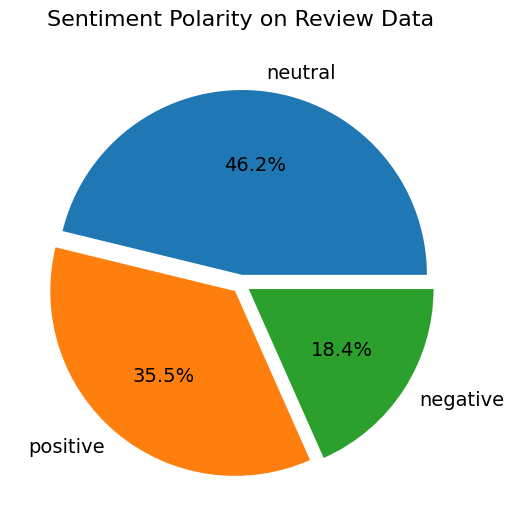

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))

sizes = clean_df['polarity'].value_counts().values

labels = clean_df['polarity'].value_counts().index.tolist()

explode = [0.05] * len(labels)

ax.pie(x=sizes, labels=labels, autopct='%1.1f%%', explode=explode, textprops={'fontsize': 14})

ax.set_title('Sentiment Polarity on Review Data', fontsize=16, pad=20)

plt.show()

# Eksplorasi Label

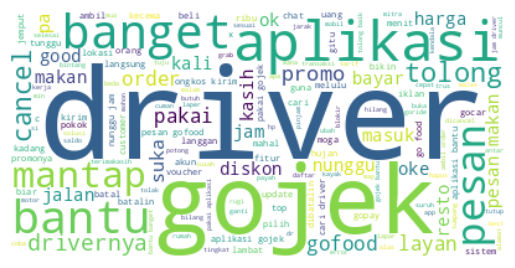

In [ ]:
# Teks data
neutral_texts = clean_df[clean_df['polarity'] == 'neutral']['text_akhir']

# Teks data
text = ' '.join(neutral_texts.astype(str).tolist())

# Membuat wordcloud
wordcloud = WordCloud(background_color='white').generate(text)

# Menampilkan WordCloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

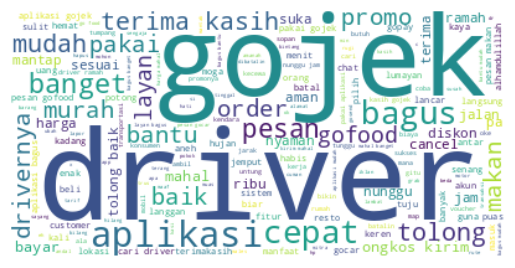

In [ ]:
# Filter hanya tweet dengan polaritas 'positive'
positive_texts = clean_df[clean_df['polarity'] == 'positive']['text_akhir']

# Teks data
text = ' '.join(positive_texts.astype(str).tolist())

# Membuat wordcloud
wordcloud = WordCloud(background_color='white').generate(text)

# Menampilkan WordCloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

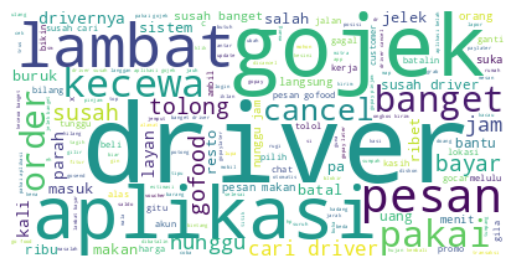

In [ ]:
# Filter hanya tweet dengan polaritas 'negative'
negative_texts = clean_df[clean_df['polarity'] == 'negative']['text_akhir']

# Teks data
text = ' '.join(negative_texts.astype(str).tolist())

# Membuat wordcloud
wordcloud = WordCloud(background_color='white').generate(text)

# Menampilkan WordCloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

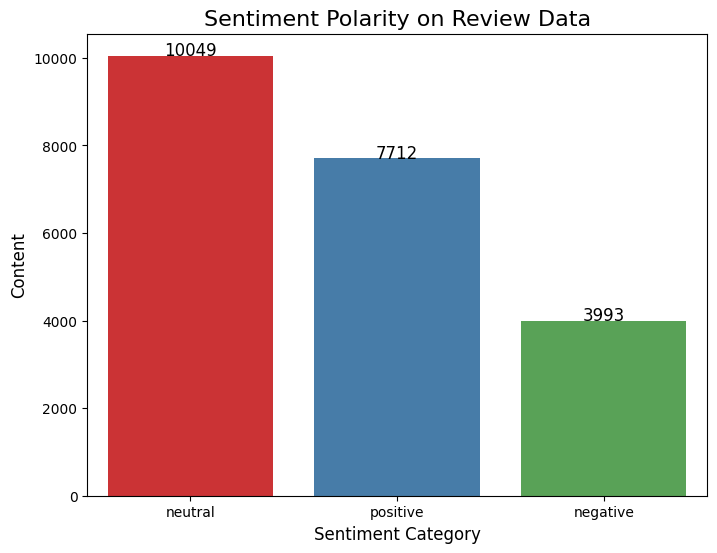

In [ ]:
# Menghitung jumlah masing-masing kategori sentimen
sentiment_counts = clean_df['polarity'].value_counts()

# Membuat plot
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=sentiment_counts.index, hue=sentiment_counts.index, y=sentiment_counts.values, palette="Set1")

# Menambahkan jumlah di atas batang
for i, count in enumerate(sentiment_counts.values):
    plt.text(i, count + 0.1, str(count), ha='center', fontsize=12, color='black')

# Menambahkan judul dan label
plt.title("Sentiment Polarity on Review Data", fontsize=16)
plt.xlabel("Sentiment Category", fontsize=12)
plt.ylabel("Content", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Menampilkan plot
plt.show()

# Model

In [ ]:
# Pisahkan data menjadi fitur (tweet) dan label (sentimen)
X = clean_df['text_akhir'].astype(str)
y = clean_df['polarity'].map({'positive': 2, 'negative': 1, 'neutral': 0})

In [ ]:
# Ekstraksi fitur dengan TF-IDF
tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1,2), max_df=0.9)
X_tfidf = tfidf.fit_transform(X)

## RF + TF-IDF + 70/30    

In [ ]:
# Bagi data menjadi data latih dan data uji
X_train, X_test, y_train_rf, y_test_rf = train_test_split(X_tfidf, y, test_size=0.3, random_state=42)

In [ ]:
# Membuat objek model Random Forest
random_forest = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)

# Melatih model Random Forest pada data pelatihan
random_forest.fit(X_train, y_train_rf)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_rf = random_forest.predict(X_train)
y_pred_test_rf = random_forest.predict(X_test)

# Evaluasi akurasi model Random Forest
accuracy_train_rf = accuracy_score(y_pred_train_rf, y_train_rf)
accuracy_test_rf = accuracy_score(y_pred_test_rf, y_test_rf)

# Menampilkan akurasi
print(f"Random Forest - Train Accuracy: {accuracy_train_rf:.4f} | Test Accuracy: {accuracy_test_rf:.4f}")
print(classification_report(y_pred_test_rf, y_test_rf))

Random Forest - Train Accuracy: 0.9993 | Test Accuracy: 0.8575
              precision    recall  f1-score   support

           0       0.90      0.83      0.86      3244
           1       0.72      0.83      0.77      1075
           2       0.87      0.92      0.89      2208

    accuracy                           0.86      6527
   macro avg       0.83      0.86      0.84      6527
weighted avg       0.86      0.86      0.86      6527



## SVM + TF-IDF + 80/20

In [ ]:
# Bagi data menjadi data latih dan data uji
X_train, X_test, y_train_svm, y_test_svm = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [ ]:
# Membuat objek model Support Vector Machine
svm = SVC(kernel='linear', class_weight='balanced', random_state=42)

# Melatih model Support Vector Machine pada data pelatihan
svm.fit(X_train, y_train_svm)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_svm = svm.predict(X_train)
y_pred_test_svm = svm.predict(X_test)

# Evaluasi akurasi model Support Vector Machine
accuracy_train_svm = accuracy_score(y_pred_train_svm, y_train_svm)
accuracy_test_svm = accuracy_score(y_pred_test_svm, y_test_svm)

# Menampilkan akurasi
print(f"Support Vector Machine - Train Accuracy: {accuracy_train_svm:.4f} | Test Accuracy: {accuracy_test_svm:.4f}")
print(classification_report(y_pred_test_svm, y_test_svm))

Support Vector Machine - Train Accuracy: 0.9791 | Test Accuracy: 0.9228
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      2066
           1       0.89      0.89      0.89       802
           2       0.93      0.96      0.94      1483

    accuracy                           0.92      4351
   macro avg       0.92      0.92      0.92      4351
weighted avg       0.92      0.92      0.92      4351



## LSTM + Tokenizing + Padding + 80/20

In [ ]:
tokenizer = Tokenizer(num_words=20000, oov_token='OOV')
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X, maxlen=100)

In [ ]:
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_lstm, X_val_lstm, y_train_lstm, y_val_lstm = train_test_split(X_train_lstm, y_train_lstm, test_size=0.125, random_state=42)

In [ ]:
# Define LSTM model
lstm_model = Sequential([
    Embedding(input_dim=20000, output_dim=128, input_length=100),
    SpatialDropout1D(0.3),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.4),
    LSTM(64),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])

# Compile model
lstm_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=5e-4),
    metrics=['accuracy']
)

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True,
    min_delta=0.001,
    mode='max'
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6
)
callbacks = [early_stopping, reduce_lr]

# Train model
history = lstm_model.fit(
    X_train_lstm, y_train_lstm,
    validation_data=(X_val_lstm, y_val_lstm),
    epochs=25,
    batch_size=64,
    verbose=1,
    callbacks=callbacks
)


Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


238/238 ━━━━━━━━━━━━━━━━━━━━ 168s 679ms/step - accuracy: 0.5571 - loss: 0.8868 - val_accuracy: 0.8350 - val_loss: 0.4156 - learning_rate: 5.0000e-04
Epoch 2/25
238/238 ━━━━━━━━━━━━━━━━━━━━ 204s 685ms/step - accuracy: 0.8868 - loss: 0.3010 - val_accuracy: 0.9242 - val_loss: 0.2274 - learning_rate: 5.0000e-04
Epoch 3/25
238/238 ━━━━━━━━━━━━━━━━━━━━ 161s 675ms/step - accuracy: 0.9551 - loss: 0.1275 - val_accuracy: 0.9260 - val_loss: 0.2158 - learning_rate: 5.0000e-04
Epoch 4/25
238/238 ━━━━━━━━━━━━━━━━━━━━ 199s 662ms/step - accuracy: 0.9800 - loss: 0.0597 - val_accuracy: 0.9439 - val_loss: 0.1831 - learning_rate: 5.0000e-04
Epoch 5/25
238/238 ━━━━━━━━━━━━━━━━━━━━ 202s 661ms/step - accuracy: 0.9851 - loss: 0.0440 - val_accuracy: 0.9407 - val_loss: 0.1882 - learning_rate: 5.0000e-04
Epoch 6/25
238/238 ━━━━━━━━━━━━━━━━━━━━ 202s 661ms/step - accuracy: 0.9905 - loss: 0.0277 - val_accuracy: 0.9540 - val_loss: 0.1783 - learning_rate: 5.0000e-04
Epoch 7/25
238/238 ━━━━━━━━━━━━━━━━━━━━ 161s 676ms/

📌 LSTM Model Evaluation
✅ Test Accuracy : 0.9460
❌ Test Loss     : 0.1874
136/136 ━━━━━━━━━━━━━━━━━━━━ 21s 153ms/step

📄 Classification Report:
              precision    recall  f1-score   support

    negative       0.94      0.95      0.94      2010
     neutral       0.94      0.90      0.92       807
    positive       0.96      0.96      0.96      1534

    accuracy                           0.95      4351
   macro avg       0.95      0.94      0.94      4351
weighted avg       0.95      0.95      0.95      4351



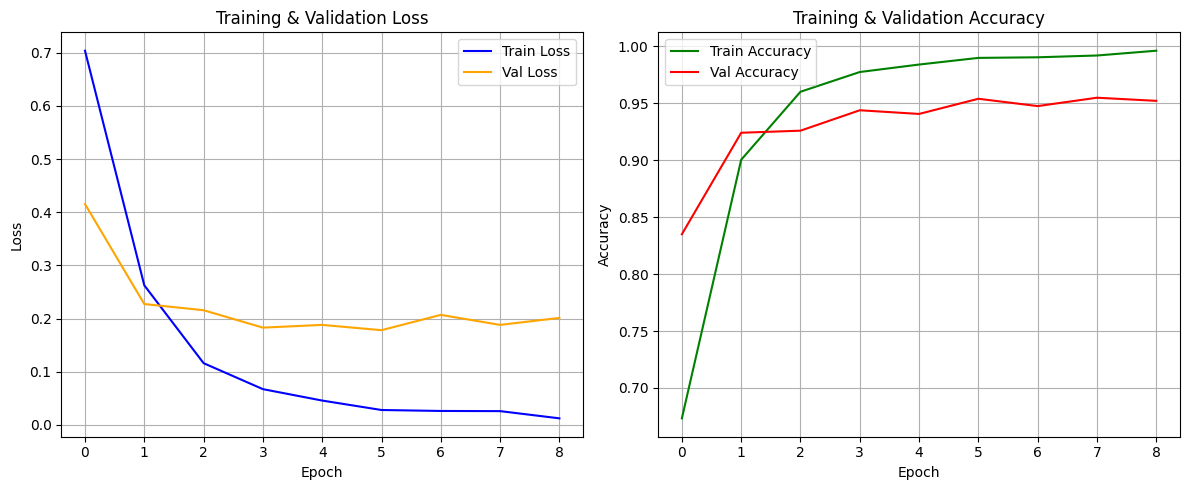

In [ ]:
# 📊 Evaluate LSTM Model
test_loss, lstm_accuracy = lstm_model.evaluate(X_test_lstm, y_test_lstm, verbose=0)
print("📌 LSTM Model Evaluation")
print(f"✅ Test Accuracy : {lstm_accuracy:.4f}")
print(f"❌ Test Loss     : {test_loss:.4f}")

# 🔍 Predict and Generate Classification Report
y_pred_lstm = np.argmax(lstm_model.predict(X_test_lstm), axis=1)
print("\n📄 Classification Report:")
print(classification_report(y_test_lstm, y_pred_lstm, target_names=['negative', 'neutral', 'positive']))

# 📈 Plot Training History
plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Val Loss', color='orange')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', color='red')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Hitung F1-Score untuk masing-masing model
f1_rf = f1_score(y_test_rf, y_pred_test_rf, average='macro')
f1_svm = f1_score(y_test_svm, y_pred_test_svm, average='macro')
f1_lstm = f1_score(y_test_lstm, y_pred_lstm, average='macro')

# Buat daftar hasil evaluasi model
results = [
    {
        'Model': 'Random Forest',
        'Accuracy': accuracy_test_rf,
        'F1-Score': f1_rf,
        'Split Ratio': '70/30',
        'Feature Type': 'TF-IDF'
    },
    {
        'Model': 'SVM',
        'Accuracy': accuracy_test_svm,
        'F1-Score': f1_svm,
        'Split Ratio': '80/20',
        'Feature Type': 'TF-IDF'
    },
    {
        'Model': 'LSTM',
        'Accuracy': lstm_accuracy,
        'F1-Score': f1_lstm,
        'Split Ratio': '80/20',
        'Feature Type': 'Word Embedding'
    }
]

# Konversi ke DataFrame
df_summary = pd.DataFrame(results)

# Format persentase untuk Accuracy dan F1-Score
df_summary['Accuracy'] = df_summary['Accuracy'].apply(lambda x: f"{x:.2%}")
df_summary['F1-Score'] = df_summary['F1-Score'].apply(lambda x: f"{x:.2%}")

# Urutkan berdasarkan akurasi secara menurun
df_summary = df_summary.sort_values(by='Accuracy', ascending=False)

# Tampilkan hasil
display(df_summary)

Summary of Model Results


,Model,Accuracy,F1-Score,Split Ratio,Feature Type
2,LSTM,94.60%,94.17%,80/20,Word Embedding
1,SVM,92.28%,91.80%,80/20,TF-IDF
0,Random Forest,85.75%,84.30%,70/30,TF-IDF


# Save Models

In [ ]:
lstm_model.save("lstm_sentiment_model.h5")

with open("svm_sentiment_model.pkl", "wb") as f:
    pickle.dump(svm, f)

with open("rf_sentiment_model.pkl", "wb") as f:
    pickle.dump(random_forest, f)

with open("vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf, f)

with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

files.download("lstm_sentiment_model.h5")
files.download("svm_sentiment_model.pkl")
files.download("rf_sentiment_model.pkl")
files.download("vectorizer.pkl")
files.download("tokenizer.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
!pip freeze > requirements.txt

# Kesimpulan

## Perbandingan antar pelatihan

- LSTM memberikan performa terbaik dengan akurasi 94.60% dan F1-Score 94.17%, menunjukkan bahwa model berbasis deep learning dengan word embedding sangat efektif dalam memahami konteks teks.
- SVM menyusul dengan akurasi 92.28% dan F1-Score 91.80%, menunjukkan hasil yang juga cukup baik saat menggunakan fitur TF-IDF.
- Random Forest memiliki performa paling rendah dengan akurasi 85.75% dan F1-Score 84.30%, meskipun masih cukup layak untuk tugas klasifikasi dasar.

## Kelemahan model

Model yang saya buat tidak sepenuhnya berhasil mendapatkan sentimen yang benar, namun dapat dilihat saya mendapatkan train dan test 92%. Meski telah mendapatkan di atas 85%, tentunya masih banyak kekurangan dari Preprocessing Text dan Modeling. Pada model kali ini lebih condong ke neutral/netral, jadi lebih banyak membaca sentimen netral daripada positive ataupun negative.

## Rekomendasi tindak lanjutan

1. Melakukan Preprocessing Text dengan lebih teliti dan memperhatikan content di dalam ulasan.
2. Memodifikasi stopword agar mencegah kata-kata yang kurang bermanfaat.
3. Memodifikasi slangword agar lexicon positive-negative lebih mengerti daripada singkatan. Karena perkembangan zaman, oleh sebab itu tidak sedikit bahasa gaul yang bertambah.
4. Melakukan pelatihan, ekstraksi fitur, dan pembagian data yang berbeda dari proyek saat ini. Hal ini dapat menjadi pertimbangan pelatihan mana yang lebih efesien dan efektif.